In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopy
import requests
from time import sleep
from random import randint
import geopandas as gpd
from shapely.geometry import Point
import datetime
import branca.colormap as cm
import time
import datetime
import gdal
import seaborn as sns

derecho911_df = pd.read_csv('../data/911_Phone Calls_Derecho_050320 050420.csv')
tornado911_df = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_incidents_df = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows=3)
tornado_incidents_df = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows=3)
build_permits_2017_2020 = pd.read_csv('../data/Building_Permits_Issued_Clean.csv')

In [2]:
## Handle NaNs ##
derech_nans = derecho911_df['ALI Latitude'].isna()
derecho911_nans_df = derecho911_df[derech_nans]
tower_not_nans = derecho911_nans_df['Cell Tower Address'].notna()
derecho911_tower_not_lat = derecho911_nans_df[tower_not_nans]
derecho911_full_filter = derecho911_tower_not_lat['Cell Tower Address'] != 'WIRELESS CALLER'
derecho911_fully_filtered = derecho911_tower_not_lat[derecho911_full_filter]
torn_nans = tornado911_df['ALI Latitude'].isna()
tornado911_nans_df = tornado911_df[torn_nans]
torn_tower_not_nans = tornado911_nans_df['Cell Tower Address'].notna()
tornado911_tower_not_lat = tornado911_nans_df[torn_tower_not_nans]

In [3]:
## TEST ANY INDIVIDUAL ADDRESS ##
test_address = '5655 FRIST BLVD'
HOST = 'https://nominatim.openstreetmap.org/search?q=' + test_address + ',Nashville,Tennessee&format=json&polygon=1&addressdetails=1'

In [4]:
def location_retrieve(addresses_in_nash):  ##A list of two-tuples (index, Cell Tower Address)
    locations = {}
    for ind, address in addresses_in_nash:
        piked_address = address.replace('PKE', 'PIKE', 1)
        HOST = 'https://nominatim.openstreetmap.org/search?q='
        HOST = HOST + piked_address
        HOST = HOST + ',Tennessee&format=json&polygon=1&addressdetails=1'
        req = requests.get(HOST)
        req_dict = req.json()        
        if len(req_dict) > 0:
            ##print(str(req_dict_list))
            result_dict = {}
            result_dict['zip'] = req_dict[0]['address']['postcode']
            if 'city' in req_dict[0]['address']:                
                result_dict['city'] = req_dict[0]['address']['city']
            elif 'village' in req_dict[0]['address']:
                result_dict['city'] = req_dict[0]['address']['village']
            else:
                result_dict['city'] = req_dict[0]['address']['hamlet']
            if 'neighbourhood' in req_dict[0]['address']:
                result_dict['hood'] = req_dict[0]['address']['neighbourhood']
            else:
                result_dict['hood'] = np.nan
            result_dict['lat'] = req_dict[0]['lat']
            result_dict['lon'] = req_dict[0]['lon']
            locations[ind] = result_dict
        else:
            locations[ind] = {'zip': 0, 'city': '', 'lat': 0.0, 'lon': 0.0}
        sleep(randint(1,4))
    return locations

#### TEST function using sample data ####
some_addresses = [(5,'5600 OBRIEN AV'), (82, '4220 HARDING PKE')]

locations = location_retrieve(some_addresses)
print(str(locations))

{5: {'zip': '37209', 'city': 'Nashville-Davidson', 'hood': 'West Nashville', 'lat': '36.1498707', 'lon': '-86.8653'}, 82: {'zip': '37205', 'city': 'Nashville-Davidson', 'hood': nan, 'lat': '36.1296963', 'lon': '-86.84464522914443'}}


In [5]:
## Create Test DataFrame ##
data = {'Seizure DateTime':['5/3/2020 18:22', '5/3/2020 18:22'],
        'CallTypeId': ['911 Calls', '911 Calls'], 'ALI Latitude': [np.nan, np.nan], 
        'ALI Longitude': [np.nan, np.nan], 'Cell Tower Address': ['5600 OBRIEN AV', '4220 HARDING PKE'], 'zip': ['37207', 37209]}
test_nan_df = pd.DataFrame(data, index=[5, 82])

def integrate_latlon(nan_df, df, address_col, lat_col, lon_col):  ## input dataframe and the string values for the column names
    loc = location_retrieve(zip(nan_df.index, nan_df[address_col]))
    for ind in loc:
        df.at[ind, lat_col] = loc[ind]['lat']
        df.at[ind, lon_col] = loc[ind]['lon']
    return df

##TEST##
integrated = integrate_latlon(test_nan_df, test_nan_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')
##integrated.head()

In [6]:
## Integrate API address fetch ** THIS CAN TAKE SEVERAL MINUTES TO RUN ##

derecho911_fill_df = integrate_latlon(derecho911_fully_filtered, derecho911_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')
tornado911_fill_df = integrate_latlon(tornado911_tower_not_lat, tornado911_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')

In [7]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

##Make a geometry column which contains points required for spatial join
derecho911_fill_df['geometry'] = derecho911_fill_df.apply(lambda row: Point(row['ALI Longitude'], row['ALI Latitude']), axis=1)
tornado911_fill_df['geometry'] = tornado911_fill_df.apply(lambda row: Point(row['ALI Longitude'], row['ALI Latitude']), axis=1)

##Make a latLong column which contains an array which is required for map markers for folium
derecho911_fill_df['latlong'] = derecho911_fill_df.apply(lambda row: [row['ALI Latitude'], row['ALI Longitude']], axis=1)
tornado911_fill_df['latlong'] = tornado911_fill_df.apply(lambda row: [row['ALI Latitude'], row['ALI Longitude']], axis=1)

tornado_incidents_df.rename(columns={'IncidentTypeDescription1': 'CallTypeId'}, inplace=True)
derecho_incidents_df.rename(columns={'IncidentTypeDescription1': 'CallTypeId'}, inplace=True)

tornado_incidents_df['geometry'] = tornado_incidents_df.apply(lambda row: Point(row['Longitude1'], row['Latitude1']), axis=1)
derecho_incidents_df['geometry'] = derecho_incidents_df.apply(lambda row: Point(row['Longitude1'], row['Latitude1']), axis=1)

tornado_incidents_df['latlong'] = tornado_incidents_df.apply(lambda row: [row['Latitude1'], row['Longitude1']], axis=1)
derecho_incidents_df['latlong'] = derecho_incidents_df.apply(lambda row: [row['Latitude1'], row['Longitude1']], axis=1)

t911_zips_geo = gpd.GeoDataFrame(tornado911_fill_df, 
                           crs = zipcodes.crs, 
                           geometry = tornado911_fill_df['geometry'])
t911_zips_gpd = gpd.sjoin(t911_zips_geo, zipcodes, op = 'within')

d911_zips_geo = gpd.GeoDataFrame(derecho911_fill_df, 
                           crs = zipcodes.crs, 
                           geometry = derecho911_fill_df['geometry'])
d911_zips_gpd = gpd.sjoin(d911_zips_geo, zipcodes, op = 'within')

tincidents_zips_geo = gpd.GeoDataFrame(tornado_incidents_df, 
                        crs = zipcodes.crs, 
                        geometry = tornado_incidents_df['geometry'])
tincidents_zips_gpd = gpd.sjoin(tincidents_zips_geo, zipcodes, op = 'within')

dincidents_zips_geo = gpd.GeoDataFrame(derecho_incidents_df, 
                        crs = zipcodes.crs, 
                        geometry = derecho_incidents_df['geometry'])
dincidents_zips_gpd = gpd.sjoin(dincidents_zips_geo, zipcodes, op = 'within')

##simple map example following Mary's intro to geo
##ax = zipcodes.plot(figsize = (8, 10), color = 'lightgreen')
##t911_geo.plot( ax = ax);
##plt.show();

In [8]:
##Try same with tiger shapefiles from US GOV - TN tract level
tract_shapes = gpd.read_file('../data/tl_2019_47_tract.shp')

d_inc_tracts_geo = gpd.GeoDataFrame(derecho_incidents_df, 
                           crs = tract_shapes.crs, 
                           geometry = derecho_incidents_df['geometry'])
d_incidents_tracts_gpd = gpd.sjoin(d_inc_tracts_geo, tract_shapes, how='right', op = 'within')
d_incidents_tracts_gpd = d_incidents_tracts_gpd[d_incidents_tracts_gpd['COUNTYFP'] == '037']

In [9]:
d911_geo = gpd.GeoDataFrame(derecho911_fill_df, 
                           crs = tract_shapes.crs, 
                           geometry = derecho911_fill_df['geometry'])

d_911_tracts_gpd = gpd.sjoin(d911_geo, tract_shapes, how='right', op = 'within')
d_911_tracts_gpd = d_911_tracts_gpd[d_911_tracts_gpd['COUNTYFP'] == '037']

In [10]:
torn_inc_geo = gpd.GeoDataFrame(tornado_incidents_df, 
                           crs = tract_shapes.crs, 
                            geometry = tornado_incidents_df['geometry'])

torn_inc_tracts_gpd = gpd.sjoin(torn_inc_geo, tract_shapes, how='right', op = 'within')
torn_inc_tracts_gpd = torn_inc_tracts_gpd[torn_inc_tracts_gpd['COUNTYFP'] == '037']

In [11]:
t911_geo = gpd.GeoDataFrame(tornado911_fill_df, 
                           crs = tract_shapes.crs, 
                           geometry = tornado911_fill_df['geometry'])

t_911_tracts_gpd = gpd.sjoin(t911_geo, tract_shapes, how='right', op = 'within')
t_911_tracts_gpd = t_911_tracts_gpd[t_911_tracts_gpd['COUNTYFP'] == '037']

In [12]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['B01003_001E']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'tract:*'  ## Census tracts
predicates['in']  = 'state:47'  ## State of Tennessee

request = requests.get(base_url, params=predicates)
col_names = ['NAME', 'Total', 'state', 'county', 'tract']
census_df = pd.DataFrame(columns=col_names, data=request.json()[1:])
census_df = census_df[census_df['county'] == '037']
census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract']
census_df = census_df.drop(['NAME'], axis=1)
census_df = census_df.dropna()
census_df['Total'] = census_df['Total'].astype('int')  ## Make numeric cols numeric

## USE IF PULLING IN ADDITIONAL CENSUS DATA THAT NEEDS TO BE TRANSLATED TO PERCENT##
##col_names_core = ["Owner Occupied", "Renter Occupied"]
##for col in col_names_core:
##    census_df["Pct_" + col] = 100 * census_df[col] / census_df["Total"]

In [ ]:
## Perform Calcs on Permits df in order to prepare to merge ##
build_permits_2017_2020 = build_permits_2017_2020[build_permits_2017_2020['Census Tract'].notna()]
build_permits_2017_2020 = build_permits_2017_2020[build_permits_2017_2020['Construction Cost'].notna()]

In [ ]:
build_permits_2017_2020['Census Tract'] = build_permits_2017_2020['Census Tract'].astype(str)
build_permits_2017_2020['Census Tract'] = build_permits_2017_2020['Census Tract'].apply(lambda x: x[:-2])

In [ ]:
##build_permits_2017_2020['Construction Cost'] = build_permits_2017_2020['Construction Cost'].apply(lambda x: x[:-2])
build_permits_2017_2020['GEOID'] = build_permits_2017_2020['Census Tract'].apply(lambda y: '470' + y)
build_permits_2017_2020['Construction Cost'] = build_permits_2017_2020['Construction Cost'].astype(int)

In [16]:
build_permits_2017_2020 = build_permits_2017_2020[build_permits_2017_2020['GEOID'].apply(lambda x: len(str(x))==11)]

In [17]:
sum_cost_by_area = build_permits_2017_2020.groupby('GEOID').agg({'Construction Cost': 'sum'})

In [ ]:
## Merge population data based on census
permit_census = pd.merge(build_permits_2017_2020, census_df, on='GEOID')
## Pull in tract geometry
tract_permit_census = pd.merge(permit_census, tract_shapes, on='GEOID')
mappable_const_df = pd.merge(sum_cost_by_area, tract_permit_census, left_index=True, right_on='GEOID')

In [19]:
mappable_const_df.rename(columns={'Construction Cost_x': 'Construction Total', 'Construction Cost_y': 'Construction Cost'}, inplace=True)

In [ ]:
mappable_const_df = mappable_const_df.drop_duplicates(subset=['GEOID'])
mappable_const_df['area_acres'] = mappable_const_df['ALAND'] / 43560.04
mappable_const_df['const_investment_per_sqft'] = mappable_const_df['Construction Total'] / mappable_const_df['area_acres'].astype('float64')
mappable_const_df['const_investment_per_sqft_per_pop'] = mappable_const_df['const_investment_per_sqft'] / mappable_const_df['Total'].astype('float64').replace({0: np.inf})


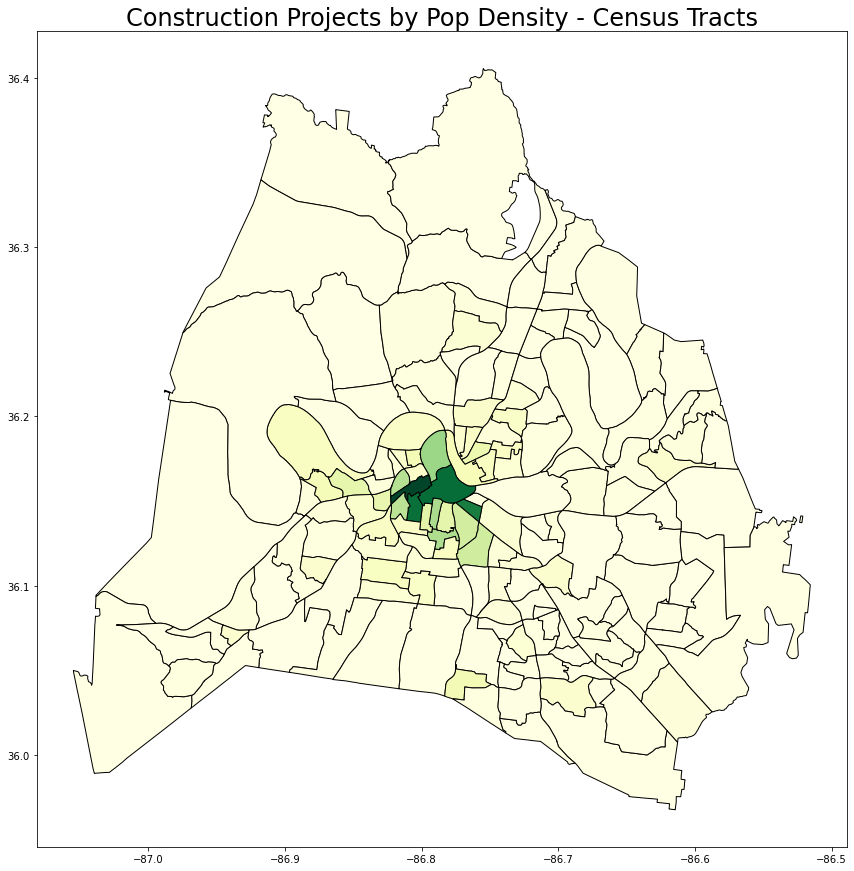

In [21]:
mappable_const_df = gpd.GeoDataFrame(mappable_const_df)
ax = mappable_const_df.plot(figsize=(15, 15), cmap='YlGn', column='const_investment_per_sqft_per_pop', edgecolor='black')

l = ax.set_title(label='Construction Projects by Pop Density - Census Tracts')
l.set_fontsize(24)
plt.show()

In [22]:
def prepare_to_map_df(df):
    merged_to_census = pd.merge(census_df, df, how='left', on='GEOID') ## Perform merge to census data
    merged_to_census['inc_counts'] = np.where(merged_to_census['CallTypeId'].isna(), 0, 1)  ## Add Column to tally incidents
    grp_count_by_tracts = merged_to_census.groupby('tract')['inc_counts'].sum().to_frame()        
    final_df = pd.merge(grp_count_by_tracts, merged_to_census, how='right', left_index=True, right_on='tract' )       
    final_df['incidents_per_pop'] = final_df['inc_counts_x'] / final_df['Total'].astype('float64').replace(0, np.inf)
    ##final_df = final_df.loc[final_df['Total'] >= 1000] ## Remove outliers
    ##final_df = final_df[final_df['incidents_per_sqft_per_pop'] != 0.0]
    final_df = final_df.drop_duplicates(subset=['tract'])  ##remove duplicate rows
    final_df = gpd.GeoDataFrame(final_df)  ##Make it back into a geodataframe
    return final_df

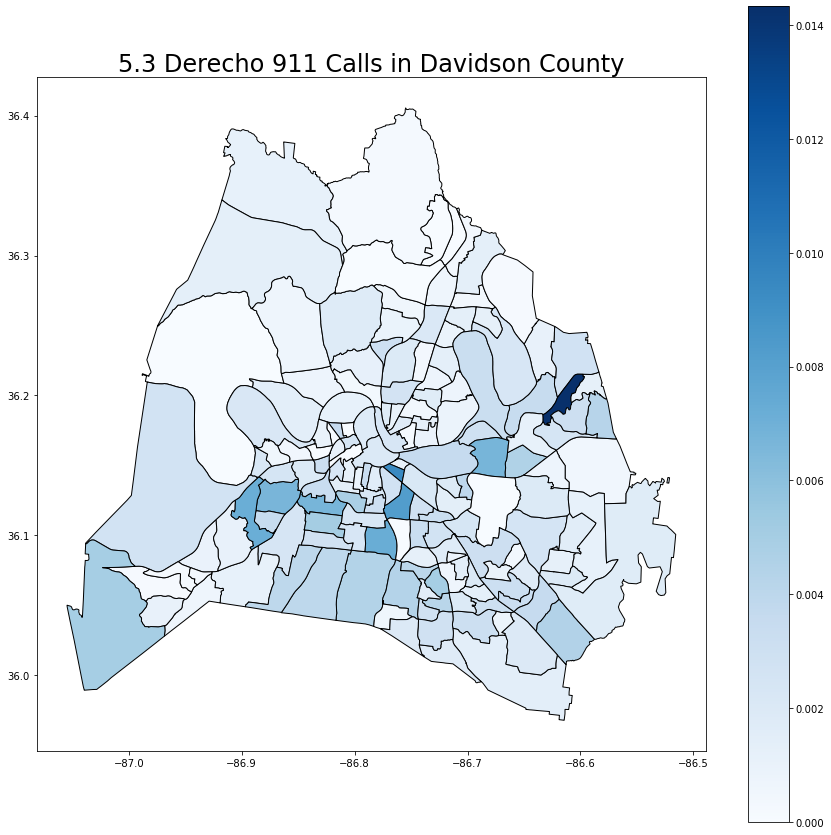

In [23]:
d_911_mappable_df = prepare_to_map_df(d_911_tracts_gpd)
fig, ax = plt.subplots(1, figsize=(15, 15))
l = ax.set_title(label='5.3 Derecho 911 Calls in Davidson County')
m = l.set_fontsize(24)

d_911_mappable_df.plot(ax=ax, cmap='Blues', column='incidents_per_pop', edgecolor='black', legend=True)
plt.savefig('Derecho_Calls_Choropleth.png')
plt.show()

In [ ]:
d_911_mappable_df

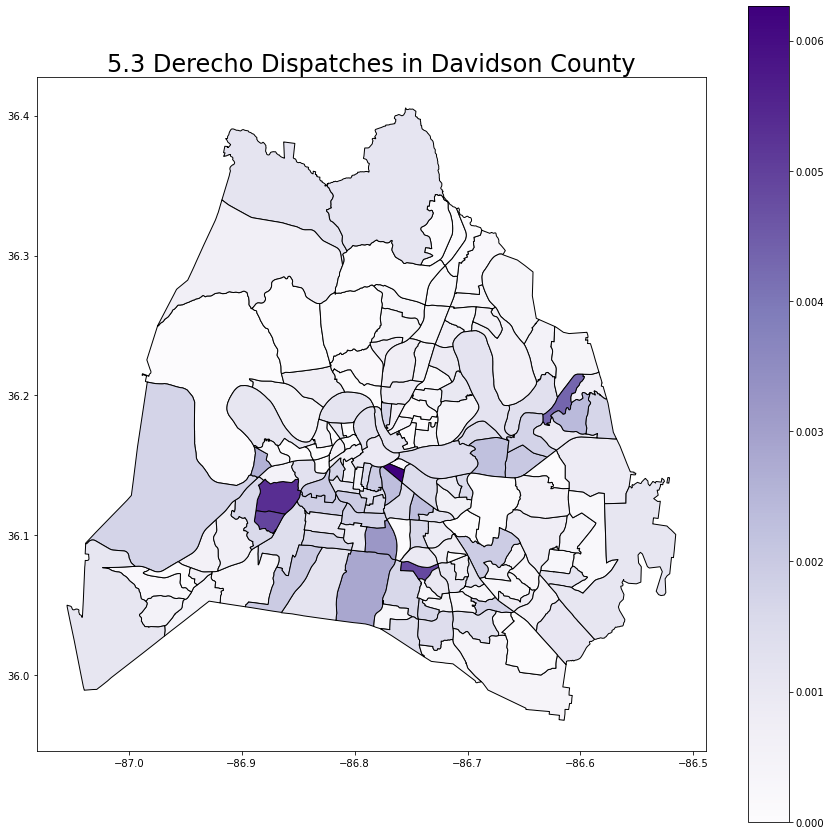

In [24]:
d_inc_mappable_df = prepare_to_map_df(d_incidents_tracts_gpd)

fig, ax = plt.subplots(1, figsize=(15, 15))
l = ax.set_title(label='5.3 Derecho Dispatches in Davidson County')
m = l.set_fontsize(24)

d_inc_mappable_df.plot(ax=ax, cmap='Purples', column='incidents_per_pop', edgecolor='black', legend=True)
plt.savefig('Derecho_Incidents_Choropleth.png')
plt.show()


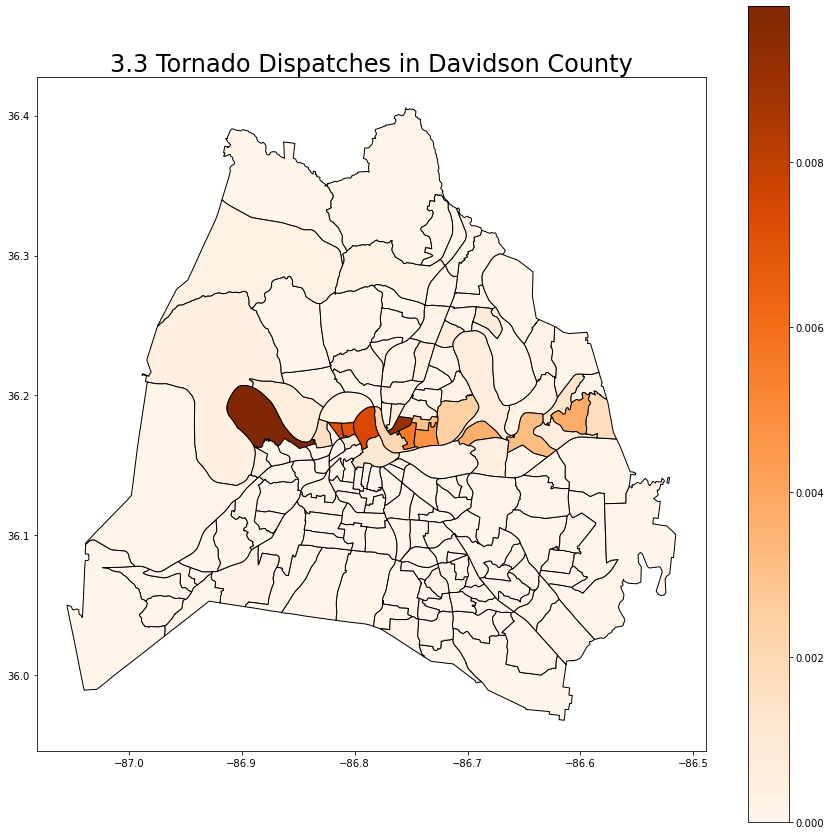

In [25]:
t_inc_mappable_df = prepare_to_map_df(torn_inc_tracts_gpd)

fig, ax = plt.subplots(1, figsize=(15, 15))
m = ax.set_title(label='3.3 Tornado Dispatches in Davidson County')
m.set_fontsize(24)
t_inc_mappable_df.plot(ax=ax, cmap='Oranges', column='incidents_per_pop', edgecolor='black', legend=True)
plt.savefig('Tornado_Incidents_Choropleth.png')
plt.show()

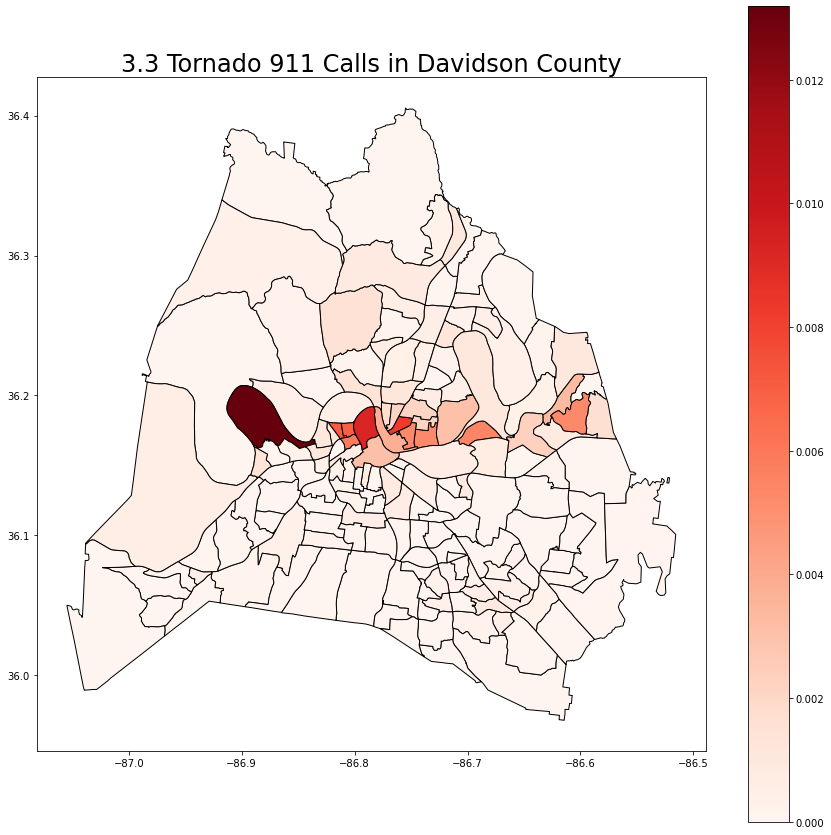

In [26]:
t_911_mappable_df = prepare_to_map_df(t_911_tracts_gpd)
fig, ax = plt.subplots(1, figsize=(15, 15))
l = ax.set_title(label='3.3 Tornado 911 Calls in Davidson County')
l.set_fontsize(24)

t_911_mappable_df.plot(ax=ax, cmap='Reds', column='incidents_per_pop', edgecolor='black', legend=True)
plt.savefig('Tornado_Calls_Choropleth.png')
plt.show()

In [ ]:
def top_x_affected_area(df, x):
    



d_911_mappable_df
d_inc_mappable_df
t_inc_mappable_df
t_911_mappable_df